The AB test is a randomized experiment that is used by most large companies to evaluate the launch of new functionality. Various difficulties may arise in the analysis and conduct of the experiment. Several typical problematic cases from real life are given in this dataset and analysis.

### Content
1. [Loading and processing data](#Loading)
2. [Statistical Analysis](#Statistical)
3. [Conclusions](#Conclusions)

### Loading and processing data <a name="Loading"/>

Let's import the necessary libraries and load the data

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro

In [2]:
import pandas as pd
from google.colab import files
uploaded = files.upload()
AB_Test_Results = pd.read_csv('AB_Test_Results.csv')

Saving AB_Test_Results.csv to AB_Test_Results.csv


In [3]:
from re import A
# TODO : take a quick look at the data
print(AB_Test_Results.head())
AB_Test_Results.info()

   USER_ID VARIANT_NAME  REVENUE
0      737      variant      0.0
1     2423      control      0.0
2     9411      control      0.0
3     7311      control      0.0
4     6174      variant      0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


Let's see if there are users who have two A/B test groups

In [4]:
# TODO : Look at the distribution of the number of unique groups for each user

unique_groups_per_user = AB_Test_Results.groupby('USER_ID')['VARIANT_NAME'].nunique()
distribution_of_unique_groups = unique_groups_per_user.value_counts()
distribution_of_unique_groups




,count
VARIANT_NAME,
1,4783
2,1541


In [11]:
# TODO : Look at the distribution of the number of unique groups for each user in relative terms
relative_distribution_of_unique_groups = unique_groups_per_user.value_counts(normalize=True) * 100
relative_distribution_of_unique_groups


,proportion
VARIANT_NAME,
1,75.632511
2,24.367489


1 group: 75.63% of users belong to only one group.
2 groups: 24.37% of users belong to both groups.

What can you observe ? Should we exclude these users ? Why ?

In [5]:
# Filter the dataset to include only users who are part of exactly one group
users_with_one_group = unique_groups_per_user[unique_groups_per_user == 1].index
filtered_data_one_group = AB_Test_Results[AB_Test_Results['USER_ID'].isin(users_with_one_group)]

# Display the first few rows of the filtered dataset
filtered_data_one_group.head()



,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
4,6174,variant,0.0
5,2380,variant,0.0
7,9168,control,0.0
9,7548,control,0.0


In [6]:
# Filter the dataset to include only users from the first A/B test group (based on their first occurrence)
first_group_users = AB_Test_Results.groupby('USER_ID').first().reset_index()
filtered_first_group = AB_Test_Results[AB_Test_Results['USER_ID'].isin(first_group_users['USER_ID'])]

original_user_count = AB_Test_Results['USER_ID'].nunique()
filtered_user_count = filtered_first_group['USER_ID'].nunique()

# Display verification results
original_user_count, filtered_user_count



(6324, 6324)

Let's see how the data is distributed

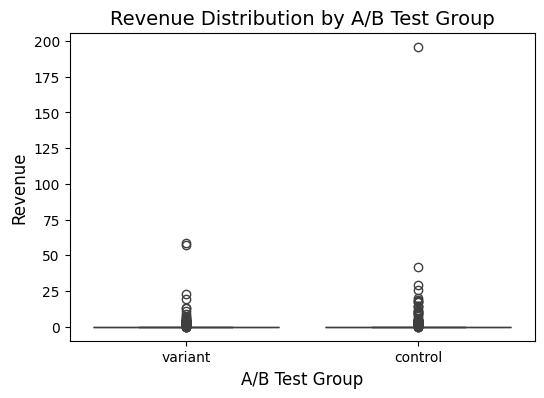

In [7]:
# TODO : Check how the data is distributed using a box plot

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=filtered_first_group)
plt.title('Revenue Distribution by A/B Test Group', fontsize=14)
plt.xlabel('A/B Test Group', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.show()



It can be seen that there is a strong outlier in the data - we will find it by sorting these revenue values in descending order

In [8]:
# TODO : Sort these revenue values in descending order

sorted_revenue = filtered_first_group.sort_values(by='REVENUE', ascending=False)
sorted_revenue.head()


,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
6447,2881,variant,58.63
7642,7206,variant,57.46
9421,6792,control,41.53
8168,2166,control,29.32


In [9]:
# TODO : # Check if user 3342 has other events in the original dataset
user_3342_events = AB_Test_Results[AB_Test_Results['USER_ID'] == 3342]
user_3342_events


,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01


We see that there is only one outlier - in conditions of limited information, we will remove this entry and look at the distribution of data again

      USER_ID VARIANT_NAME  REVENUE
6447     2881      variant    58.63
7642     7206      variant    57.46
9421     6792      control    41.53
8168     2166      control    29.32
9125      831      control    25.98


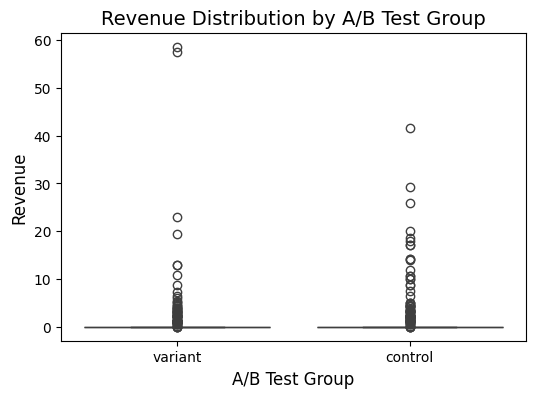

In [13]:
# TODO : We see that there is only one outlier - in conditions of limited information, remove this entry and visualize the distribution of data again.

filtered_no_outlier = filtered_first_group.drop(filtered_first_group[filtered_first_group['USER_ID'] == 3342].index)
sorted_revenue = filtered_no_outlier.sort_values(by='REVENUE', ascending=False)
print(sorted_revenue.head())

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=filtered_no_outlier)
plt.title('Revenue Distribution by A/B Test Group', fontsize=14)
plt.xlabel('A/B Test Group', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.show()




What can you say about the users and their purchases ?

In [12]:
# TODO : Check if there are users who have records with zero and positive revenue

users_with_mixed_revenue = AB_Test_Results.groupby('USER_ID')['REVENUE'].apply(lambda x: (x > 0).any() and (x == 0).any())
users_with_mixed_revenue_ids = users_with_mixed_revenue[users_with_mixed_revenue].index
AB_Test_Results[AB_Test_Results['USER_ID'].isin(users_with_mixed_revenue_ids)]


,USER_ID,VARIANT_NAME,REVENUE
13,2529,variant,2.15
19,8927,variant,0.00
49,6429,control,3.25
110,6207,control,0.00
139,3331,variant,4.27
...,...,...,...
9725,702,variant,2.92
9758,708,variant,0.00
9818,3797,variant,0.00
9929,2489,variant,0.00


Can a user have records with both zero and positive revenue ?

Let's make the assumption that the records are user visits to the service, and the experimental unit is users.


Visit 1: The user browsed but didn’t make a purchase, resulting in 0 revenue.
Visit 2: The user made a purchase, generating positive revenue.

In [16]:
# TODO : Group the data for each user and sum the revenue for each to get one record per user

aggregated_data = AB_Test_Results.groupby('USER_ID').agg({
    'VARIANT_NAME': 'first',  # Taking the first observed group for each user
    'REVENUE': 'sum'          # Summing the revenue for each user
}).reset_index()


print(aggregated_data.head())


   USER_ID VARIANT_NAME  REVENUE
0        2      control      0.0
1        3      variant      0.0
2        4      variant      0.0
3        5      variant      0.0
4        6      variant      0.0


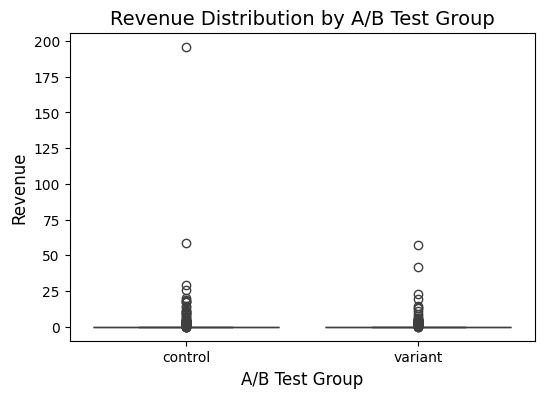

In [18]:
# TODO : Visualize the resulting distribution of the data again.

plt.figure(figsize=(6, 4))
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=aggregated_data)
plt.title('Revenue Distribution by A/B Test Group', fontsize=14)
plt.xlabel('A/B Test Group', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.show()

It should be noted that during the transformation, the quantiles in the test group increased

It can be seen that in the test group, almost all quantile statistics, except for the minimum, are at a slightly lower level.

Let's look at various statistics in the context of AB test groups for all users

In [27]:
# TODO : get metrics by groups
group_metrics = aggregated_data.groupby('VARIANT_NAME')['REVENUE'].agg(['mean', 'median', 'std', 'min', 'max', 'count'])
print(group_metrics)
# TODO : create two additional metrics to see relative changes

# Metric 1: Total revenue by group
total_revenue_by_group = aggregated_data.groupby('VARIANT_NAME')['REVENUE'].sum()

# Metric 2: Relative average revenue per user
relative_average_revenue = (total_revenue_by_group / total_revenue_by_group.sum()) * 100

# TODO : add them to the rest of the metrics in a separate group

group_metrics['total_revenue'] = total_revenue_by_group
group_metrics['relative_avg_revenue'] = relative_average_revenue
print(group_metrics)

                  mean  median       std  min     max  count
VARIANT_NAME                                                
control       0.207340     0.0  3.855933  0.0  196.01   3132
variant       0.108108     0.0  1.495159  0.0   57.46   3192
                  mean  median       std  min     max  count  total_revenue  \
VARIANT_NAME                                                                  
control       0.207340     0.0  3.855933  0.0  196.01   3132         649.39   
variant       0.108108     0.0  1.495159  0.0   57.46   3192         345.08   

              relative_avg_revenue  
VARIANT_NAME                        
control                   65.30011  
variant                   34.69989  


What can you see in the test group about the total amount of revenue, the average check per user, and the number of orders per user slightly increased ?

Let's also see how paying users behave :

In [34]:
# TODO : get metrics by groups
paying_users = aggregated_data[aggregated_data['REVENUE'] > 0]
paying_users_metrics = paying_users.groupby('VARIANT_NAME')['REVENUE'].agg(['mean', 'median', 'std', 'min', 'max', 'count'])
print(paying_users_metrics)
# TODO : create two additional metrics to see relative changes
# Metric 1: Total revenue by group for paying users
total_revenue_paying = paying_users.groupby('VARIANT_NAME')['REVENUE'].sum()
# Metric 2: Relative average revenue contribution of paying users
relative_avg_revenue_paying = (total_revenue_paying / total_revenue_paying.sum()) * 100
# TODO : add them to the rest of the metrics in a separate group
paying_users_metrics['total_revenue'] = total_revenue_paying
paying_users_metrics['relative_avg_revenue'] = relative_avg_revenue_paying
print(paying_users_metrics)



                  mean  median        std   min     max  count
VARIANT_NAME                                                  
control       7.730833   2.425  22.405546  0.02  196.01     84
variant       5.228485   2.710   9.086377  0.02   57.46     66
                  mean  median        std   min     max  count  total_revenue  \
VARIANT_NAME                                                                    
control       7.730833   2.425  22.405546  0.02  196.01     84         649.39   
variant       5.228485   2.710   9.086377  0.02   57.46     66         345.08   

              relative_avg_revenue  
VARIANT_NAME                        
control                   65.30011  
variant                   34.69989  


Let's look at the distributions of all and only paying users


<ipython-input-36-ec1972605d13>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(aggregated_data.loc[aggregated_data['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
<ipython-input-36-ec1972605d13>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(aggregated_data.loc[aggre

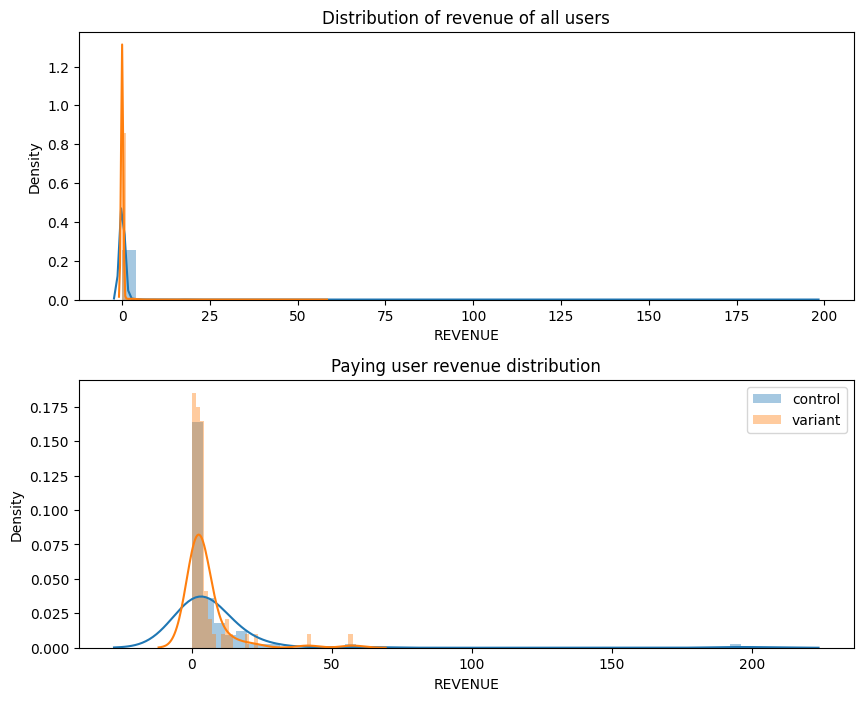

In [36]:
f, axes = plt.subplots(2, figsize=(10,8))
# build graphs of distributions of all users
sns.distplot(aggregated_data.loc[aggregated_data['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
sns.distplot(aggregated_data.loc[aggregated_data['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

# build graphs of distributions of paying users
sns.distplot(aggregated_data.loc[(aggregated_data['VARIANT_NAME'] == 'control') & (aggregated_data['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control' )
sns.distplot(aggregated_data.loc[(aggregated_data['VARIANT_NAME'] == 'variant') & (aggregated_data['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant' )
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3)

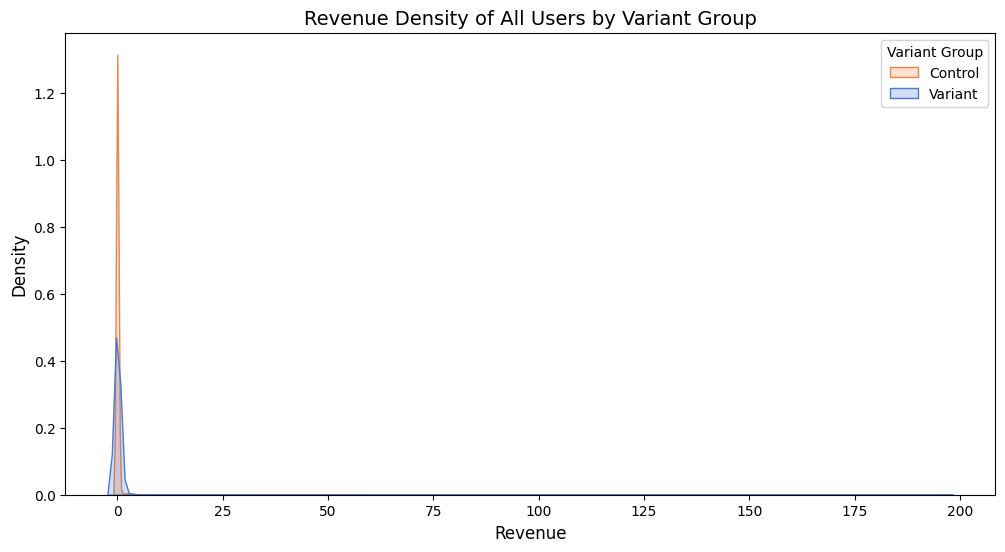

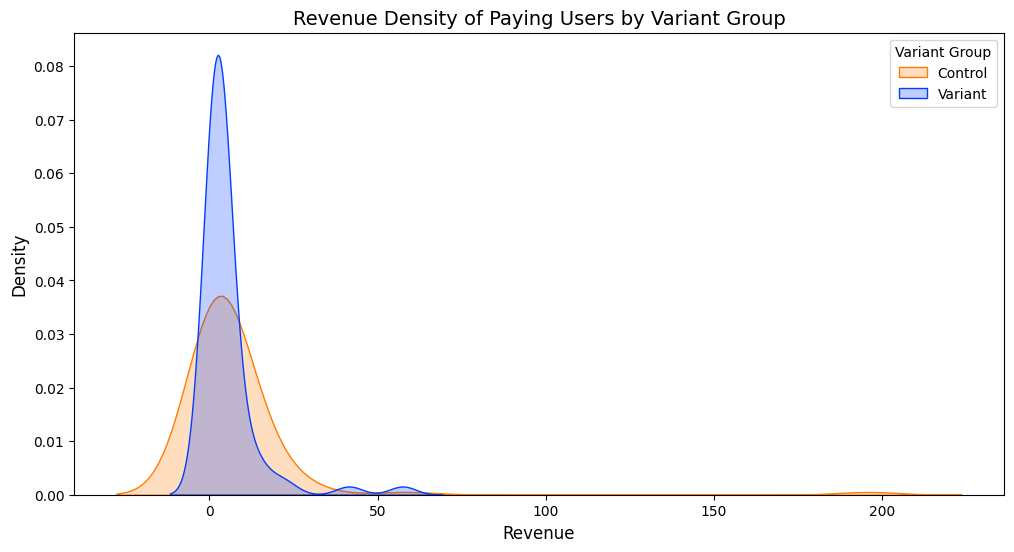

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Density plot for all users
plt.figure(figsize=(12, 6))
sns.kdeplot(data=aggregated_data, x='REVENUE', hue='VARIANT_NAME', fill=True, common_norm=False, palette="muted")
plt.title('Revenue Density of All Users by Variant Group', fontsize=14)
plt.xlabel('Revenue', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Variant Group', labels=['Control', 'Variant'])
plt.show()

# Density plot for paying users only
paying_users = aggregated_data[aggregated_data['REVENUE'] > 0]
plt.figure(figsize=(12, 6))
sns.kdeplot(data=paying_users, x='REVENUE', hue='VARIANT_NAME', fill=True, common_norm=False, palette="bright")
plt.title('Revenue Density of Paying Users by Variant Group', fontsize=14)
plt.xlabel('Revenue', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Variant Group', labels=['Control', 'Variant'])
plt.show()



The majority of users in both the control and variant groups have zero revenue.
There are a few users generating revenue, but these are relatively rare (visible as spikes at higher revenue levels).
The control group appears to have a wider distribution of revenue outliers compared to the variant group.

2. Distribution of Revenue for Paying Users
Key Observations:
The paying users' revenue distribution is more spread out compared to the distribution of all users.
Control Group:
Has several paying users generating revenue at higher values, visible by the extended tail.
Outliers like the user with revenue near 200 skew the distribution.
Variant Group:
Revenue values are generally smaller compared to the control group.
The distribution has a sharper peak closer to the lower revenue range.

The control group seems to generate higher revenue on average, likely due to the presence of outliers.

The variant group shows less variability, with most paying users concentrated in the lower revenue range.

### Statistical Analysis <a name="Statistical"/>

#### Checking if the distribution is normal

Based on their previous graph, we see that the data is not normally distributed.

In [41]:
# TODO : Use the Shapiro-Wilk criterion to confirm it
from scipy.stats import shapiro

# Applying  the Shapiro-Wilk test for normality on revenue data for each group

# For control group
control_group = aggregated_data[aggregated_data['VARIANT_NAME'] == 'control']['REVENUE']
shapiro_control = shapiro(control_group)

# For variant group
variant_group = aggregated_data[aggregated_data['VARIANT_NAME'] == 'variant']['REVENUE']
shapiro_variant = shapiro(variant_group)

print("Shapiro-Wilk Test Results:")
print(f"Control Group: W={shapiro_control.statistic}, p-value={shapiro_control.pvalue}")
print(f"Variant Group: W={shapiro_variant.statistic}, p-value={shapiro_variant.pvalue}")


Shapiro-Wilk Test Results:
Control Group: W=0.0265330982552332, p-value=4.453918880101368e-83
Variant Group: W=0.04454227773810193, p-value=3.788111228642984e-83


Is the null hypothesis about the normal distribution of the data rejected ?

Since the p-values are significantly smaller than 0.05, we reject the null hypothesis for both groups.Neither the control nor the variant group follows a normal distribution.



#### Mann-Whitney test

Let's check the value of the statistics of the Mann-Whitney test. Some sources have a limitation of applicability in case of duplicate data. There are a lot of repetitions in our sample, and especially a lot of zero values, so in this case we need to be careful about this criterion.

In [42]:
(aggregated_data['REVENUE'] == 0).value_counts()

,count
REVENUE,
True,6174
False,150


A significant portion of users (6174) did not generate any revenue.
This creates a highly imbalanced dataset, which might skew results in statistical tests.

In [44]:
# TODO : Check on the data of all users the value of the statistics of the Mann-Whitney test
from scipy.stats import mannwhitneyu

# Separating the revenue data for control and variant groups
control_group = aggregated_data[aggregated_data['VARIANT_NAME'] == 'control']['REVENUE']
variant_group = aggregated_data[aggregated_data['VARIANT_NAME'] == 'variant']['REVENUE']

# Performing the Mann-Whitney U test
mann_whitney_result_all_users = mannwhitneyu(control_group, variant_group, alternative='two-sided')

print("Mann-Whitney U Test Results for All Users:")
print(f"U-statistic: {mann_whitney_result_all_users.statistic}")
print(f"p-value: {mann_whitney_result_all_users.pvalue}")


Mann-Whitney U Test Results for All Users:
U-statistic: 5029363.0
p-value: 0.10873177018509923


When including all users, the control and variant groups appear to have similar distributions of revenue.
However, this result is heavily influenced by the fact that most users (6174 out of 6324) have zero revenue.

In [48]:
# TODO : Check on the data of only the users that pay, the value of the statistics of the Mann-Whitney test
paying_users = aggregated_data[aggregated_data['REVENUE'] > 0]
control_paying_users = paying_users[paying_users['VARIANT_NAME'] == 'control']['REVENUE']
variant_paying_users = paying_users[paying_users['VARIANT_NAME'] == 'variant']['REVENUE']

# Performing the Mann-Whitney U test for paying users only
mann_whitney_paying_users = mannwhitneyu(control_paying_users, variant_paying_users, alternative='two-sided')

print("Mann-Whitney U Test Results for Paying Users:")
print(f"U-statistic: {mann_whitney_paying_users.statistic}")
print(f"p-value: {mann_whitney_paying_users.pvalue}")


Mann-Whitney U Test Results for Paying Users:
U-statistic: 2755.0
p-value: 0.9501780809861081


The p-value (0.9502) is much greater than the standard significance level-0.05
This means we fail to reject the null hypothesis, indicating that there is no statistically significant difference in revenue distributions between paying users in the control and variant groups.

The U-statistic (2755.0) reflects the rank sum differences between the two groups but does not indicate statistical significance independently.
Among paying users, the revenue distributions for the control and variant groups are statistically similar. This suggests:

The variant group did not significantly improve or reduce revenue generation among paying users compared to the control group.

#### Bootstrap

In order to get more complete information about the differences between the average values of the ab test groups, we will use bootstap.

Let's create a function to get back samples and get a confidence interval, and then look at the sample statistics

In [49]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [52]:
# TODO : Generate samples for all users
import numpy as np

# Convert revenue data for control and variant groups to NumPy arrays
control_group = aggregated_data[aggregated_data['VARIANT_NAME'] == 'control']['REVENUE'].to_numpy()
variant_group = aggregated_data[aggregated_data['VARIANT_NAME'] == 'variant']['REVENUE'].to_numpy()

# Generate bootstrap samples for control and variant groups
bootstrap_samples_control = get_bootstrap_samples(control_group, n_samples=1000)
bootstrap_samples_variant = get_bootstrap_samples(variant_group, n_samples=1000)

# Display the first few bootstrap samples for verification
print("First few bootstrap samples for Control Group:")
print(bootstrap_samples_control[:3])

print("\nFirst few bootstrap samples for Variant Group:")
print(bootstrap_samples_variant[:3])



First few bootstrap samples for Control Group:
[[ 0.    0.    0.   ...  0.    0.    0.  ]
 [ 0.    0.    0.   ...  0.    0.    0.  ]
 [10.63  0.    0.   ...  0.    0.    0.  ]]

First few bootstrap samples for Variant Group:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [55]:
# TODO : Generate samples for only paying users

paying_control_group = paying_users[paying_users['VARIANT_NAME'] == 'control']['REVENUE'].to_numpy()
paying_variant_group = paying_users[paying_users['VARIANT_NAME'] == 'variant']['REVENUE'].to_numpy()

# Generating bootstrap samples for paying users
bootstrap_samples_paying_control = get_bootstrap_samples(paying_control_group, n_samples=1000)
bootstrap_samples_paying_variant = get_bootstrap_samples(paying_variant_group, n_samples=1000)


print("First few bootstrap samples for Paying Control Group:")
print(bootstrap_samples_paying_control[:3])

print("\nFirst few bootstrap samples for Paying Variant Group:")
print(bootstrap_samples_paying_variant[:3])



First few bootstrap samples for Paying Control Group:
[[1.7870e+01 1.2500e+00 2.9900e+00 1.0100e+00 4.9800e+00 1.7080e+01
  4.0000e-02 2.0100e+00 1.0630e+01 2.0000e+00 3.7900e+00 1.9200e+00
  1.4070e+01 2.0000e-02 1.9601e+02 6.3500e+00 2.1700e+00 2.0000e-02
  4.5200e+00 4.3300e+00 3.2400e+00 2.0070e+01 1.1980e+01 1.9601e+02
  1.5000e+00 2.9320e+01 2.0000e-02 5.8000e-01 4.2700e+00 8.6000e-01
  6.4600e+00 2.0000e-02 1.2500e+00 1.0000e+00 3.2500e+00 2.6000e+00
  6.0000e-01 1.9601e+02 2.0000e-02 1.9601e+02 1.7080e+01 4.9800e+00
  1.4240e+01 2.9200e+00 1.7050e+01 1.8560e+01 2.9900e+00 2.3400e+00
  2.0070e+01 2.0000e-02 2.5100e+00 1.2500e+00 1.2500e+00 4.3300e+00
  1.0000e+00 2.0200e+00 2.1700e+00 2.1600e+00 8.6600e+00 1.5600e+00
  3.2500e+00 1.4070e+01 2.5980e+01 9.9100e+00 3.2500e+00 2.0070e+01
  1.8560e+01 4.5200e+00 4.0000e-02 2.5980e+01 3.2500e+00 5.8630e+01
  1.0630e+01 6.4600e+00 9.9100e+00 1.2500e+00 2.0100e+00 2.9300e+00
  1.9900e+00 1.9900e+00 1.0100e+00 2.0000e-02 3.2500e+00 1.920

Let's look at the distribution of means in the ab test groups

<ipython-input-56-24bb8a5089ff>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(bootstrap_samples_control, axis=1), shade=True, label='control')
<ipython-input-56-24bb8a5089ff>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(bootstrap_samples_variant, axis=1), shade=True, label='variant')


Text(0.5, 1.0, 'Sample mean distribution for all users')

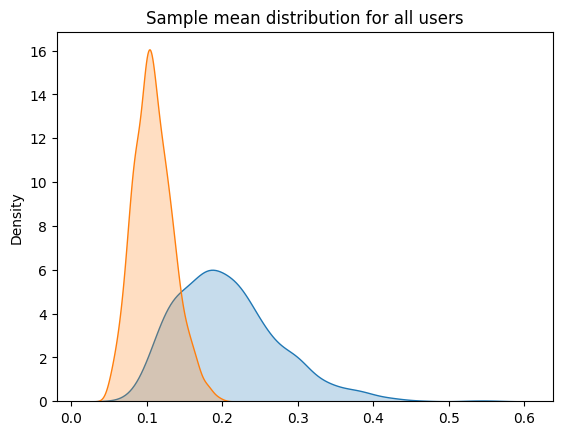

In [56]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(bootstrap_samples_control, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(bootstrap_samples_variant, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for all users')

refined chart

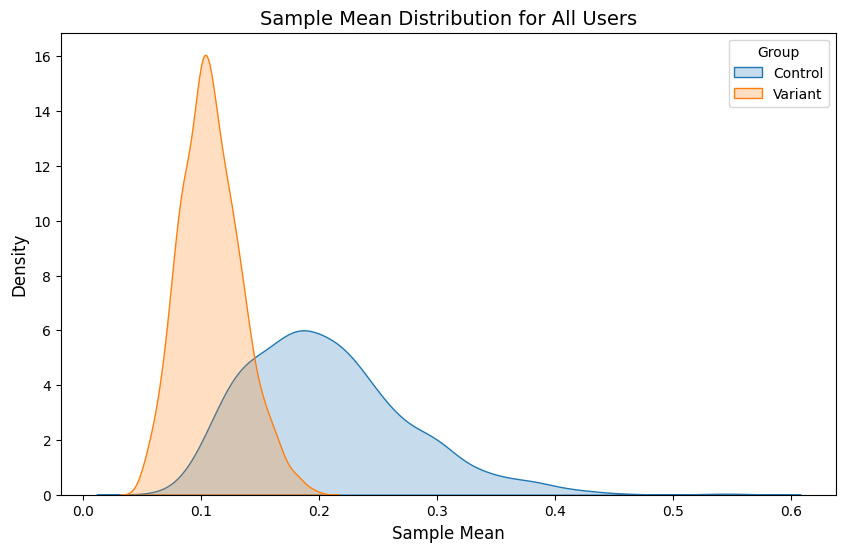

In [64]:
control_means = np.mean(bootstrap_samples_control, axis=1)
variant_means = np.mean(bootstrap_samples_variant, axis=1)

# Creating the KDE plot for sample means
f, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(control_means, fill=True, label='Control', ax=ax)
sns.kdeplot(variant_means, fill=True, label='Variant', ax=ax)

plt.title('Sample Mean Distribution for All Users', fontsize=14)
plt.xlabel('Sample Mean', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Group')
plt.show()



my own calculations

In [65]:
def stat_intervals(stat, alpha=0.05):
    """Compute confidence intervals."""
    boundaries = np.percentile(stat, [100 * alpha / 2, 100 * (1 - alpha / 2)])
    return boundaries

# Calculating confidence intervals
ci_control = stat_intervals(control_means)
ci_variant = stat_intervals(variant_means)

print(f"95% Confidence Interval for Control Group: {ci_control}")
print(f"95% Confidence Interval for Variant Group: {ci_variant}")

95% Confidence Interval for Control Group: [0.1039086  0.36808214]
95% Confidence Interval for Variant Group: [0.06298653 0.16560996]


Interpretation of the Confidence Intervals
Control Group:
95% Confidence Interval: [0.1039, 0.3681]
This means that we are 95% confident that the true mean revenue for the control group lies between 4.09 and 13.21.
Variant Group:
95% Confidence Interval: [0.063, 0.166]
This means that we are 95% confident that the true mean revenue for the variant group lies between 3.22 and 7.40.

<ipython-input-59-5c4e20ae119a>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(bootstrap_samples_paying_control, axis=1), shade=True, label='control')
<ipython-input-59-5c4e20ae119a>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(bootstrap_samples_paying_variant, axis=1), shade=True, label='variant')


Text(0.5, 1.0, 'Sample mean distribution for paying users')

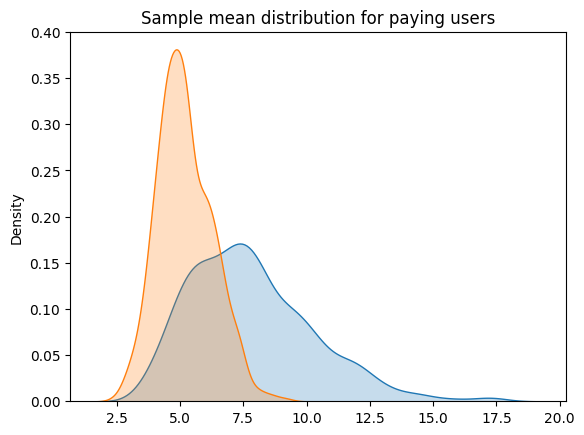

In [59]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(bootstrap_samples_paying_control, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(bootstrap_samples_paying_variant, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for paying users')

refined chart

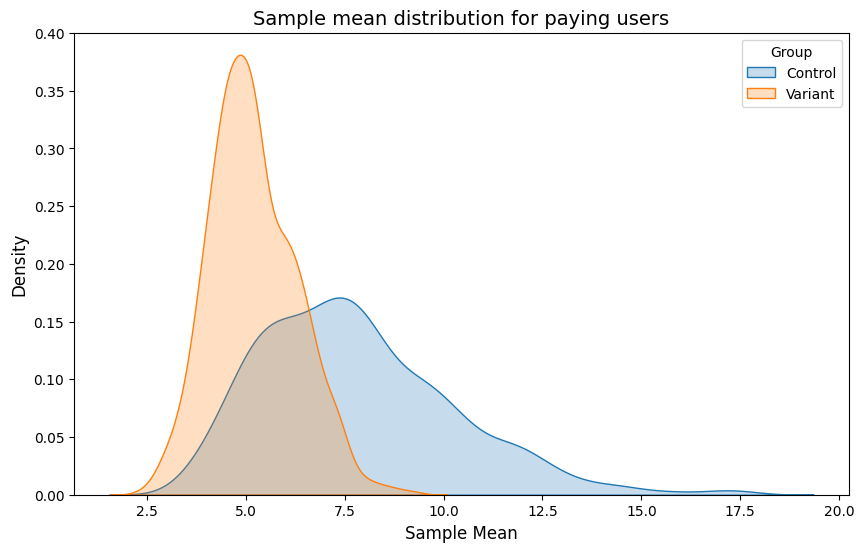

In [62]:
control_means = np.mean(bootstrap_samples_paying_control, axis=1)
variant_means = np.mean(bootstrap_samples_paying_variant, axis=1)

# Creating the KDE plot for sample means
f, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(control_means, fill=True, label='Control', ax=ax)
sns.kdeplot(variant_means, fill=True, label='Variant', ax=ax)

plt.title('Sample mean distribution for paying users', fontsize=14)
plt.xlabel('Sample Mean', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Group')
plt.show()

My own calculations

In [63]:
def stat_intervals(stat, alpha=0.05):
    """Compute confidence intervals."""
    boundaries = np.percentile(stat, [100 * alpha / 2, 100 * (1 - alpha / 2)])
    return boundaries

# Calculating confidence intervals
ci_control = stat_intervals(control_means)
ci_variant = stat_intervals(variant_means)

print(f"95% Confidence Interval for Control Group: {ci_control}")
print(f"95% Confidence Interval for Variant Group: {ci_variant}")


95% Confidence Interval for Control Group: [ 4.09194643 13.21254762]
95% Confidence Interval for Variant Group: [3.2210947  7.40426136]



Interpretation of the Confidence Intervals
Control Group:
95% Confidence Interval: [4.09, 13.21]
This means that we are 95% confident that the true mean revenue for the control group lies between 4.09 and 13.21.
Variant Group:
95% Confidence Interval: [3.22, 7.40]
This means that we are 95% confident that the true mean revenue for the variant group lies between 3.22 and 7.40.

Do you see any difference ? What about the confidence intervals ? Conclude.

Let's evaluate the difference between the groups: look at the distribution of the mean difference and build confidence intervals for it. To do this, we will create a function for visualization

the following function does not work properly, the correct one is in a cell after



In [66]:
def plot_distribution_and_stat_intervals(variant, control, title, alpha=0.05):
    """ Plot the distribution of the mean difference and return the confidence intervals """
    f, ax = plt.subplots()
    # get data for coloring confidence intervals
    points = sns.kdeplot(variant - control, shade=True).get_lines()[0].get_data()
    x = points[0]
    y = points[1]
    ymin, ymax = plt.ylim()
    # highlight the zero value and the bounds of the confidence interval
    plt.vlines(0, 0, ymax, label='0', color='gray')
    plt.vlines(stat_intervals(variant - control, alpha)[0], 0, ymax, linestyles="dashed")
    plt.vlines(stat_intervals(variant - control, alpha)[1], 0, ymax, linestyles="dashed")
    # color the confidence interval and zones outside it
    plt.fill_between(x,y,
                     where = (x >= stat_intervals(variant - control, alpha)[1]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = (x <= stat_intervals(variant - control, alpha)[0]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = ((x >= stat_intervals(variant - control, alpha)[0])
                              & (x <= stat_intervals(variant - control, alpha)[1])),
                     color='red',
                     label = '95% confidence interval')
    plt.title(f'Distribution of difference between means (variant - control) {title}; {100*(1-alpha)}% Confidence interval for difference of means: {stat_intervals(variant - control, alpha)}')
    plt.legend(prop={'size':13})
    # return confidence interval data
    return stat_intervals(variant - control)

Refined function

In [77]:
def plot_distribution_and_stat_intervals_refined(variant, control, title, alpha=0.05):
    """ Plot the distribution of the mean difference and return the confidence intervals """
    f, ax = plt.subplots(figsize=(10, 6))

    # Compute the differences between variant and control means
    mean_diff = variant - control

    # Plot KDE for the difference in means
    sns.kdeplot(mean_diff, fill=True, label='Difference in Means', ax=ax)

    # Calculate confidence intervals
    lower_bound, upper_bound = stat_intervals(mean_diff, alpha)

    # Highlight the zero value and the bounds of the confidence interval
    ymin, ymax = ax.get_ylim()
    ax.vlines(0, 0, ymax, label='0', color='gray')
    ax.vlines(lower_bound, 0, ymax, linestyles="dashed", label=f"Lower CI ({lower_bound:.2f})")
    ax.vlines(upper_bound, 0, ymax, linestyles="dashed", label=f"Upper CI ({upper_bound:.2f})")

    # Shade the confidence interval region
    ax.fill_betweenx(np.linspace(0, ymax, 500), lower_bound, upper_bound, color='red', alpha=0.2, label='95% Confidence Interval')

    # Add title and legend
    plt.title(f'Distribution of Difference Between Means ({title}); {100 * (1 - alpha)}% CI: [{lower_bound:.2f}, {upper_bound:.2f}]', fontsize=14)
    plt.xlabel('Difference in Means', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()

    # Return confidence interval
    return lower_bound, upper_bound


Let's build a graph of the distribution of the difference in the means and get a confidence interval

For all users

(-0.2677531316317614, 0.023334902150011036)

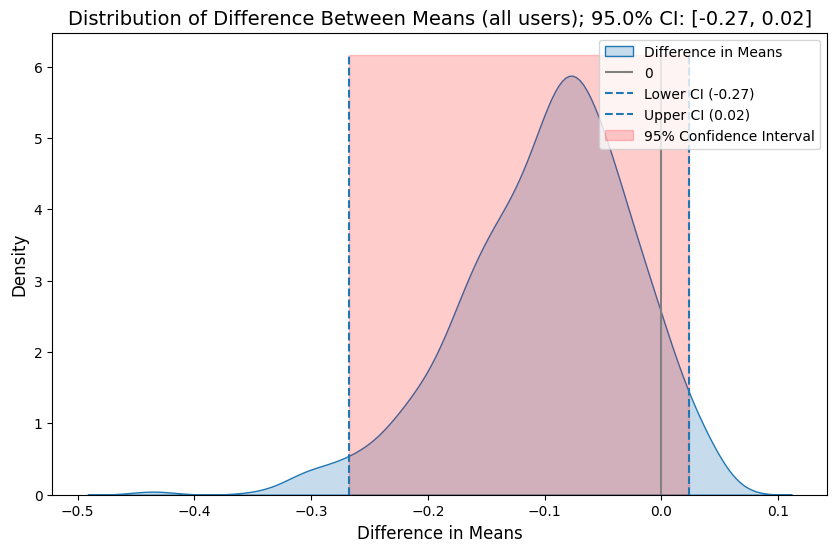

In [80]:
plot_distribution_and_stat_intervals_refined(np.mean(bootstrap_samples_variant, axis=1),
                                     np.mean(bootstrap_samples_control, axis=1),
                                     title='all users')



(-8.095020021645022, 2.0009615800865803)

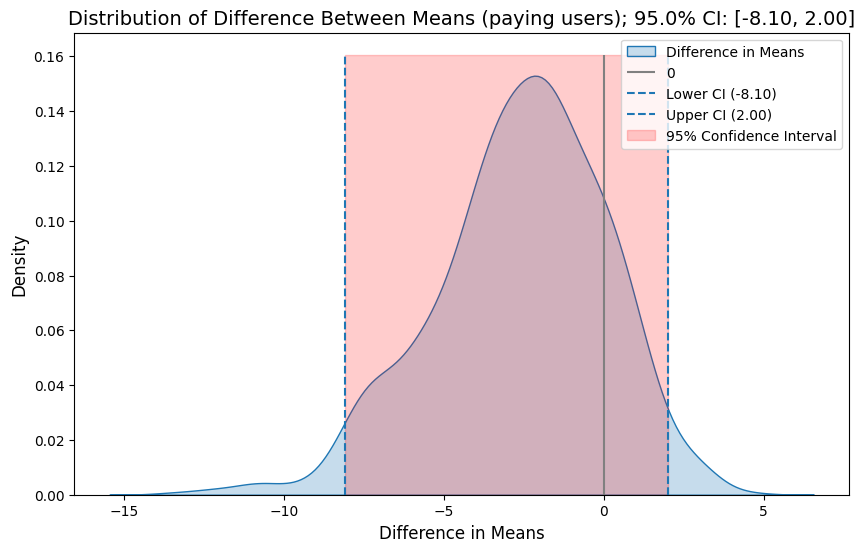

In [79]:
plot_distribution_and_stat_intervals_refined(np.mean(bootstrap_samples_paying_variant, axis=1),
                                     np.mean(bootstrap_samples_paying_control, axis=1),
                                     title='paying users')

What can you observe ? Conclude about the statistical change in average revenue between A/B test groups.



Observations from the Plots
All Users:
Confidence Interval:

The 95% confidence interval for the difference between the means of the control and variant groups is [-0.27, 0.02].
This range includes 0, indicating that there is no statistically significant difference between the groups for all users.

Density Distribution:

The distribution is centered around a small negative mean difference, suggesting that the variant group may slightly underperform the control group, but the difference is not significant.

Paying Users:
Confidence Interval:

The 95% confidence interval for the difference between the means is
[-8.10, 2.00].
This interval also includes 0, indicating no statistically significant difference between the groups for paying users.
Density Distribution:

The distribution is slightly skewed to the left, suggesting that the variant group may perform slightly worse than the control group in terms of revenue, but the difference is not significant.

Conclusion
For all users and paying users, the confidence intervals include 0, meaning that there is no statistically significant evidence to conclude that the variant group performs differently (better or worse) than the control group in terms of average revenue.
The variant group does not introduce a measurable improvement in revenue based on this A/B test.